<a href="https://colab.research.google.com/github/Nahuel023/IM_SMCA/blob/main/SMCA_Correccion_de_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🕒 Muestreo original ≈ 600 s
Parámetros de control usados:
 {'set_T': 22.0, 'set_H': 72.0, 'band_T': 2.0, 'band_H': 4.0, 'lock_frio': 600, 'lock_secador': 600, 'lock_humidif': 120, 'humidif_on_time': 300, 'humidif_pwm': True, 'pwm_window': 30, 'k_frio_T': -0.072, 'k_frio_H': -0.2, 'k_secador_H': -1.0, 'k_humidif_H': 0.8, 'k_natural_T': 0.082, 'k_natural_H': 0.1}


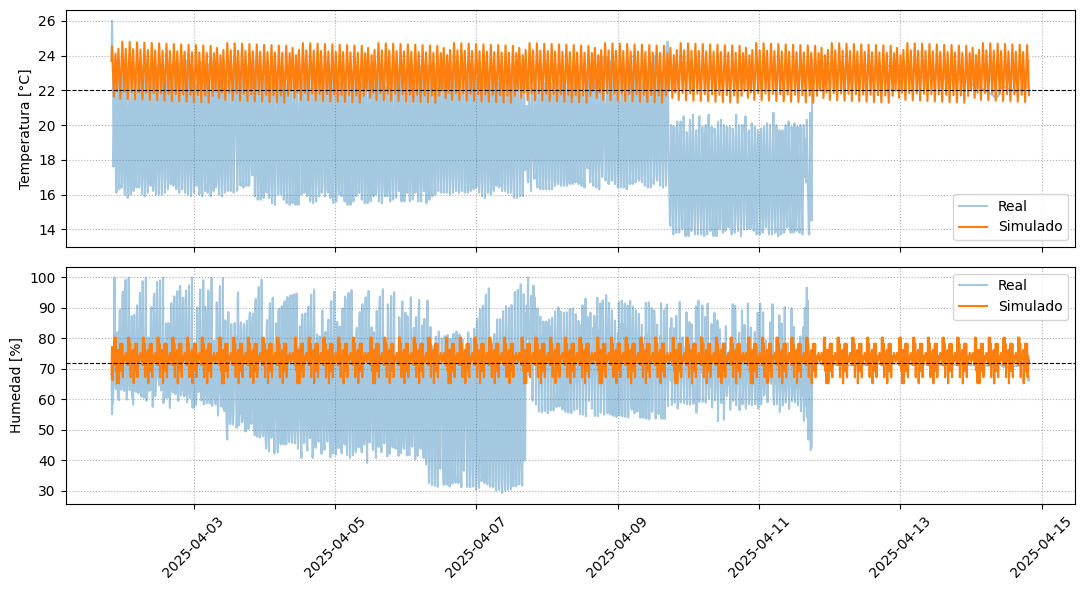

In [ ]:
# ==============================================================
# SMCA — Simulador simple para “jugar” con parámetros de control
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict

# ---------- 1.  Cargar los datos originales -------------------
FILE = '/content/drive/MyDrive/2025/SMCA_Pruebas/DATOS SECADERO 2025 - Sheet1.csv'   # <- cambia si hace falta
raw = (
    pd.read_csv(FILE, skiprows=11, names=['id','datetime','humidity','temperature','x','y'])
      .query('id != "id"')                                           # header repetido
      .assign(datetime=lambda df: pd.to_datetime(df['datetime'],
                                                 format='%d/%m/%Y %H:%M:%S'),
              humidity=lambda df: df['humidity'].str.replace(',','.').astype(float),
              temperature=lambda df: df['temperature'].str.replace(',','.').astype(float))
      .sort_values('datetime')
      .reset_index(drop=True)
)

dt_s = (raw['datetime'].iloc[1] - raw['datetime'].iloc[0]).total_seconds()
print(f'🕒 Muestreo original ≈ {dt_s:.0f} s')

# ---------- 2.  Parámetros de control que PODEMOS MODIFICAR ----
@dataclass
class ControlParams:
    # consigna
    set_T: float = 20.0        # °C
    set_H: float = 80.0        # %Hr

    # bandas
    band_T: float = 2.0        # ±°C
    band_H: float = 3.0        # ±%Hr

    # lock‑outs / tiempos mínimos  (segundos)
    lock_frio: int = 10*60
    lock_secador: int = 10*60
    lock_humidif: int =  2*60

    # duraciones fijas
    humidif_on_time: int = 5*60   # si se usa modo “bomba 5 min”
    humidif_pwm: bool = False     # ← pon a True para probar modo PWM
    pwm_window: int = 60          # ancho de la ventana PWM (s)

    # modelo dinámico (pendientes simplificadas)
    k_frio_T: float = -0.072      # °C por minuto cuando el frío está ON
    k_frio_H: float = -0.20       # %Hr por minuto (descenso aparente)
    k_secador_H: float = -1.0     # %Hr por minuto
    k_humidif_H: float =  0.8     # %Hr por minuto
    k_natural_T: float = +0.082   # °C por minuto cuando todo está OFF
    k_natural_H: float = +0.10    # %Hr por minuto de inercia/filtraciones


params = ControlParams(
    set_T = 22.0,
    set_H = 72.0,
    band_H = 4.0,
    humidif_pwm = True,          # ← ejemplo: PWM activado
    pwm_window = 30,
)

print('Parámetros de control usados:\n', asdict(params))

# ---------- 3.  Simulación paso a paso -------------------------
n = len(raw)
sim_T = np.empty(n); sim_H = np.empty(n)
relay_frio = False;  relay_sec = False; relay_hum = False
t_last_frio_off = t_last_sec_off = t_last_hum_off = -1e9
hum_on_elapsed = 0

# condiciones iniciales = primeras mediciones reales
sim_T[0], sim_H[0] = raw['temperature'][0], raw['humidity'][0]

for i in range(1, n):
    now = raw['datetime'][i]
    t = (now - raw['datetime'][0]).total_seconds()

    # --- evaluar frío -------------------------------------------------
    if relay_frio:
        if sim_T[i-1] <= params.set_T:           # histéresis inferior
            relay_frio = False
            t_last_frio_off = t
    else:
        if (sim_T[i-1] >= params.set_T + params.band_T
                and t - t_last_frio_off >= params.lock_frio):
            relay_frio = True

    # --- evaluar secador ---------------------------------------------
    if relay_sec:
        if sim_H[i-1] <= params.set_H:
            relay_sec = False
            t_last_sec_off = t
    else:
        if (sim_H[i-1] >= params.set_H + params.band_H
                and t - t_last_sec_off >= params.lock_secador):
            relay_sec = True

    # --- evaluar humidificador ---------------------------------------
    if params.humidif_pwm:           # → modo PWM en ventanas
        # duty proporcional al error (muy simple)
        duty = max(0, min(1, (params.set_H - sim_H[i-1]) / params.band_H))
        time_in_window = (t % params.pwm_window)
        relay_hum = (time_in_window < duty * params.pwm_window)
    else:                            # → modo “bomba 5 min”
        if relay_hum:
            hum_on_elapsed += dt_s
            if (hum_on_elapsed >= params.humidif_on_time
                    or sim_H[i-1] >= params.set_H):
                relay_hum = False
                t_last_hum_off = t
        else:
            if (sim_H[i-1] <= params.set_H - params.band_H
                    and t - t_last_hum_off >= params.lock_humidif):
                relay_hum = True
                hum_on_elapsed = 0

    # --- actualizar dinámica -----------------------------------------
    dT = params.k_natural_T
    dH = params.k_natural_H
    if relay_frio:
        dT = params.k_frio_T
        dH += params.k_frio_H
    if relay_sec:
        dH += params.k_secador_H
    if relay_hum:
        dH += params.k_humidif_H

    sim_T[i] = sim_T[i-1] + dT * dt_s / 60
    sim_H[i] = sim_H[i-1] + dH * dt_s / 60

# ---------- 4.  Plots -----------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)
ax[0].plot(raw['datetime'], raw['temperature'], label='Real', alpha=.4)
ax[0].plot(raw['datetime'], sim_T, label='Simulado', lw=1.5)
ax[0].axhline(params.set_T, color='k', ls='--', lw=.8)
ax[0].set_ylabel('Temperatura [°C]')
ax[0].legend(); ax[0].grid(True, ls=':')

ax[1].plot(raw['datetime'], raw['humidity'], label='Real', alpha=.4)
ax[1].plot(raw['datetime'], sim_H, label='Simulado', lw=1.5)
ax[1].axhline(params.set_H, color='k', ls='--', lw=.8)
ax[1].set_ylabel('Humedad [%]')
ax[1].legend(); ax[1].grid(True, ls=':')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 5.  Guardar resultado (opcional) -------------------------
# out = raw[['datetime']].copy()
# out['sim_temperature'] = sim_T
# out['sim_humidity']    = sim_H
# out.to_csv('/content/simulated_SMCA.csv', index=False)
# print('CSV con la simulación guardado en /content/simulated_SMCA.csv')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

🕒 Paso de muestreo de los datos: 600 s
Parámetros usados:
 {'set_T': 18.0, 'set_H': 80.0, 'band_T': -2, 'band_H': -4, 'lock_frio': 600, 'lock_sec': 600, 'lock_hum': 120, 'k_frio_T': -0.072, 'k_frio_H': -0.2, 'k_sec_H': -1.0, 'k_hum_H': 0.8, 'k_nat_T': 0.082, 'k_nat_H': 0.1, 'pwm_period': 60, 'pwm_duty': 0.5}


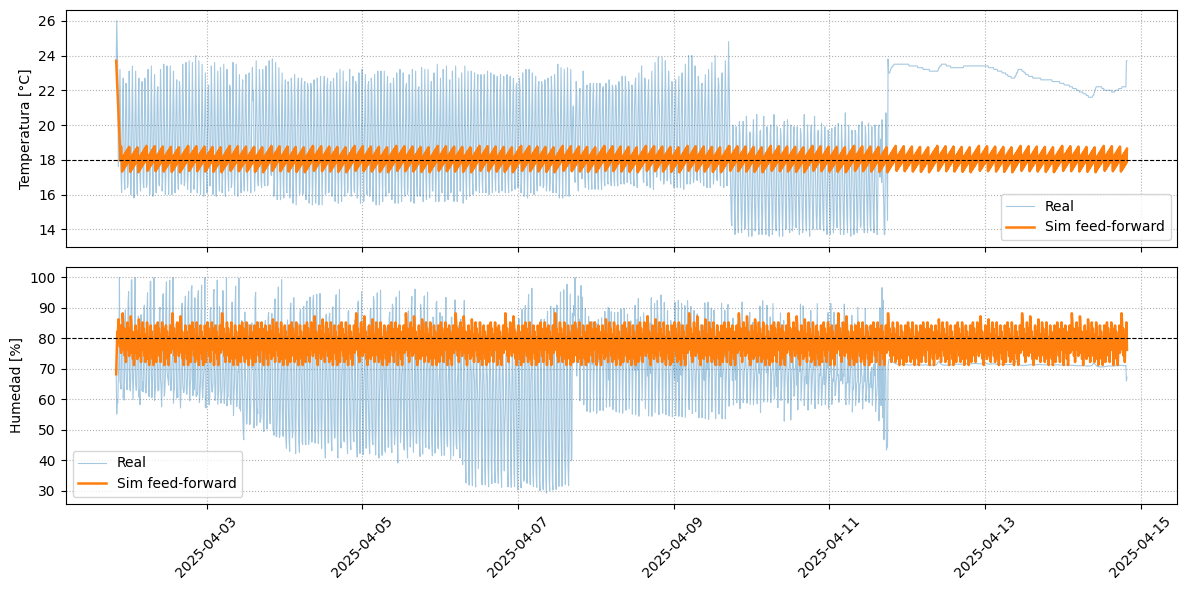


📝  Interpretación rápida de las curvas:
    • La línea 'Real' muestra cómo se comportó la cámara en tu histórico.
    • La línea 'Sim feed‑forward' refleja el mismo histórico pero
      aplicando la lógica FEED‑FORWARD: cada vez que el frío está ON,
      el humidificador se enciende automáticamente 30 s sí / 30 s no.
    • Si el modelo está bien calibrado, deberías ver que la curva
      simulada de %Hr ya NO cae a ~40 % y tampoco asciende a ~100 %.
    • Ajusta setpoints o bandas y vuelve a ejecutar para ‘jugar’
      con diferentes escenarios sin tocar tu firmware real.



In [ ]:
# ==============================================================
#  SMCA – Simulación con FEED‑FORWARD de temperatura (estrategia 3.2)
#  --------------------------------------------------------------
#  Idea: Mientras el frío está ON se dispara un ciclo PWM fijo
#        (duty = 50 %, 30 s encendido / 30 s apagado) del
#        humidificador para compensar la caída aparente de %Hr.
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict

# ---------- 1) Cargar datos reales ------------------------------------
FILE = '/content/drive/MyDrive/2025/SMCA_Pruebas/DATOS SECADERO 2025 - Sheet1.csv'  # ← ajusta ruta si hace falta
raw = (
    pd.read_csv(FILE, skiprows=11,
                names=['id','datetime','humidity','temperature','x','y'])
      .query('id != "id"')                           # elimina fila extra de cabecera
      .assign(datetime=lambda df: pd.to_datetime(df['datetime'],
                                                 format='%d/%m/%Y %H:%M:%S'),
              humidity=lambda df: df['humidity'].str.replace(',','.').astype(float),
              temperature=lambda df: df['temperature'].str.replace(',','.').astype(float))
      .sort_values('datetime')
      .reset_index(drop=True)
)

# Paso de muestreo real (segundos) – lo usaremos para escalar pendientes
dt_s = (raw['datetime'].iloc[1] - raw['datetime'].iloc[0]).total_seconds()
print(f'🕒 Paso de muestreo de los datos: {dt_s:.0f} s')

# ---------- 2) Parámetros del controlador -----------------------------
@dataclass
class Params:
    # consignas
    set_T: float = 18.0     # °C
    set_H: float = 80.0     # %Hr

    # bandas de histéresis
    band_T: float = -2     # ±°C
    band_H: float = -4     # ±%Hr

    # lock‑outs (segundos) para proteger compresor y resistencias
    lock_frio: int = 10*60
    lock_sec:  int = 10*60
    lock_hum:  int = 2*60

    # parámetros del modelo de cámara (pendientes simplificadas)
    k_frio_T: float = -0.072   # °C/min cuando frío ON
    k_frio_H: float = -0.20    # %Hr/min caída aparente por enfriar
    k_sec_H : float = -1.0     # %Hr/min que quita el secador
    k_hum_H : float =  0.8     # %Hr/min que añade el humidificador
    k_nat_T : float = +0.082   # °C/min recalentamiento natural
    k_nat_H : float = +0.10    # %Hr/min incremento natural de humedad

    # ------- parámetros específicos de feed‑forward -------------------
    pwm_period: int = 60       # longitud de la ventana PWM (s)
    pwm_duty  : float = 0.5    # 50 %  → 30 s ON / 30 s OFF


P = Params()   # instancia – puedes cambiar valores y re‑ejecutar
print('Parámetros usados:\n', asdict(P))

# ---------- 3) Arrays para la simulación ------------------------------
n = len(raw)
sim_T = np.empty(n); sim_H = np.empty(n)

# Estados de relé (bool) y marcas temporales (s)
relay_frio = relay_sec = relay_hum = False
t_last_frio_off = t_last_sec_off = t_last_hum_off = -1e9

# Condición inicial = primera medición real
sim_T[0], sim_H[0] = raw['temperature'][0], raw['humidity'][0]

# ---------- 4) Bucle de simulación paso a paso ------------------------
#  Recorremos todas las filas del CSV y, para cada instante,
#  aplicamos la lógica ON/OFF + FEED‑FORWARD
for i in range(1, n):
    # Tiempo absoluto (s) desde el comienzo de la serie
    t_abs = (raw['datetime'][i] - raw['datetime'][0]).total_seconds()

    # -------- 4.1  LÓGICA DEL RELÉ DE FRÍO ----------------------------
    if relay_frio:
        if sim_T[i-1] <= P.set_T:                # banda inferior
            relay_frio = False
            t_last_frio_off = t_abs
    else:
        if (sim_T[i-1] >= P.set_T + P.band_T and
            t_abs - t_last_frio_off >= P.lock_frio):
            relay_frio = True

    # -------- 4.2  LÓGICA DEL RELÉ DE SECADOR -------------------------
    if relay_sec:
        if sim_H[i-1] <= P.set_H:                # banda inferior
            relay_sec = False
            t_last_sec_off = t_abs
    else:
        if (sim_H[i-1] >= P.set_H + P.band_H and
            t_abs - t_last_sec_off >= P.lock_sec):
            relay_sec = True

    # -------- 4.3  FEED‑FORWARD DE HUMIDIFICADOR ----------------------
    #  Mientras el FRÍO está encendido trabajamos en PWM fijo 50 %:
    #  - El periodo completo es pwm_period (60 s)
    #  - Humidificador ON en la primera mitad de la ventana
    if relay_frio:
        time_in_window = t_abs % P.pwm_period
        relay_hum = (time_in_window < P.pwm_period * P.pwm_duty)
    #  Cuando el frío está OFF volvemos a la lógica habitual:
    else:
        if relay_hum:
            # Apagar si ya estamos en banda o sobre‑humedecidos
            if sim_H[i-1] >= P.set_H:
                relay_hum = False
                t_last_hum_off = t_abs
        else:
            # Encender si estamos por debajo de la banda y pasaron 2 min
            if (sim_H[i-1] <= P.set_H - P.band_H and
                t_abs - t_last_hum_off >= P.lock_hum):
                relay_hum = True

    # -------- 4.4  DINÁMICA DE LA CÁMARA ------------------------------
    #  Sumamos las pendientes correspondientes.  Las conversiones
    #  /60 son para pasar de "por minuto" → "por dt_s segundos"
    dT = P.k_nat_T
    dH = P.k_nat_H
    if relay_frio:
        dT = P.k_frio_T
        dH += P.k_frio_H
    if relay_sec:
        dH += P.k_sec_H
    if relay_hum:
        dH += P.k_hum_H

    sim_T[i] = sim_T[i-1] + dT * dt_s / 60
    sim_H[i] = sim_H[i-1] + dH * dt_s / 60

# ---------- 5) Graficar resultado -------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# --- Temperatura
ax[0].plot(raw['datetime'], raw['temperature'],
           label='Real', alpha=0.4, lw=0.8)
ax[0].plot(raw['datetime'], sim_T,
           label='Sim feed‑forward', lw=1.8)
ax[0].axhline(P.set_T, ls='--', c='k', lw=.8)
ax[0].set_ylabel('Temperatura [°C]')
ax[0].legend(); ax[0].grid(ls=':')

# --- Humedad
ax[1].plot(raw['datetime'], raw['humidity'],
           label='Real', alpha=0.4, lw=0.8)
ax[1].plot(raw['datetime'], sim_H,
           label='Sim feed‑forward', lw=1.8)
ax[1].axhline(P.set_H, ls='--', c='k', lw=.8)
ax[1].set_ylabel('Humedad [%]')
ax[1].legend(); ax[1].grid(ls=':')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 6) ¿Qué estoy viendo? -------------------------------------
print("""
📝  Interpretación rápida de las curvas:
    • La línea 'Real' muestra cómo se comportó la cámara en tu histórico.
    • La línea 'Sim feed‑forward' refleja el mismo histórico pero
      aplicando la lógica FEED‑FORWARD: cada vez que el frío está ON,
      el humidificador se enciende automáticamente 30 s sí / 30 s no.
    • Si el modelo está bien calibrado, deberías ver que la curva
      simulada de %Hr ya NO cae a ~40 % y tampoco asciende a ~100 %.
    • Ajusta setpoints o bandas y vuelve a ejecutar para ‘jugar’
      con diferentes escenarios sin tocar tu firmware real.
""")
